1. 모델에서 logloss 평균값을 만들어서 보기 편하게 하기
2. begin month 집중해서 처리해보기
3. ratio 생성 -> 가지고 놀기

# 1. 기본 설정 및 데이터 로드 

In [1]:
import warnings
warnings.filterwarnings('ignore')
# import glob
import pandas as pd
import numpy as np

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from lightgbm import LGBMClassifier
from sklearn.model_selection import StratifiedKFold,train_test_split
from sklearn.preprocessing import  LabelEncoder, OneHotEncoder
import random

pd.set_option('display.max_row', 500)
pd.set_option('display.max_columns', 100)

In [2]:
train = pd.read_csv('./data/train.csv')
train = train.drop(['index','FLAG_MOBIL'], axis=1)
train.fillna('NAN', inplace=True) 


test = pd.read_csv('./data/test.csv')
test = test.drop(['index', 'FLAG_MOBIL'], axis=1)
test.fillna('NAN', inplace=True)

submit = pd.read_csv('./data/sample_submission.csv')

#### 1.1 데이터 확인 

In [16]:
print(train.shape, test.shape)
train.head()

(26457, 18) (10000, 17)


,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,DAYS_EMPLOYED,work_phone,phone,email,occyp_type,family_size,begin_month,credit
0,F,N,N,0,202500.0,Commercial associate,Higher education,Married,Municipal apartment,-13899,-4709,0,0,0,NAN,2.0,-6.0,1.0
1,F,N,Y,1,247500.0,Commercial associate,Secondary / secondary special,Civil marriage,House / apartment,-11380,-1540,0,0,1,Laborers,3.0,-5.0,1.0
2,M,Y,Y,0,450000.0,Working,Higher education,Married,House / apartment,-19087,-4434,0,1,0,Managers,2.0,-22.0,2.0
3,F,N,Y,0,202500.0,Commercial associate,Secondary / secondary special,Married,House / apartment,-15088,-2092,0,1,0,Sales staff,2.0,-37.0,0.0
4,F,Y,Y,0,157500.0,State servant,Higher education,Married,House / apartment,-15037,-2105,0,0,0,Managers,2.0,-26.0,2.0


In [ ]:
train[train['income_type'] == 'Commercial associate']['occyp_type'].value_counts()
#train[train['income_type'] == 'Commercial associate']['income_total'].mean()

In [ ]:
train[train['income_type'] == 'Working']['occyp_type'].value_counts()
#train[train['income_type'] == 'Working']['income_total'].mean()

1. 연속형 변수, 범주형 변수가 존재한다
2. 결측값(occpy type)이 8171개 있다. -> 일단 NAN로 대체
3. 중복값도 존재하는 것 같다.

In [ ]:
train.describe()

1. FLAG_MOBIL를 제거해주자. (완료)
2. DAYS_EMPLOYED(이상값 존재한다) (완료)
3. income_total를 log 취해주자 (완료)
4. child_num, family_size도 log를 취하거나 빈도화 하자.(로그값 임시)
5. DAYS_BIRTH, DAYS_EMPLOYED, begin_month를 가지고 놀자

#### 1. begin_month 빈도화 처리

In [ ]:
import seaborn as sns

sns.distplot(train.begin_month)

In [ ]:
## 빈도 범주화
train['begin_month_tran'] = train['begin_month']
cond_over_0_10 = train['begin_month_tran'] >= -10
cond_over_10_20 = (train['begin_month_tran'] < -10) & (train['begin_month_tran'] >= -20)
cond_over_20_30 = (train['begin_month_tran'] < -20) & (train['begin_month_tran'] >= -30)
cond_over_30_40 = (train['begin_month_tran'] < -30) & (train['begin_month_tran'] >= -40)
cond_over_40_50 = (train['begin_month_tran'] < -40) & (train['begin_month_tran'] >= -50)
cond_over_50_60 = (train['begin_month_tran'] <= -50)

# 비율
print(train[cond_over_0_10].shape[0]/train.shape[0])
print(train[cond_over_10_20].shape[0]/train.shape[0])
print(train[cond_over_20_30].shape[0]/train.shape[0])
print(train[cond_over_30_40].shape[0]/train.shape[0])
print(train[cond_over_40_50].shape[0]/train.shape[0])
print(train[cond_over_50_60].shape[0]/train.shape[0])

#### 2. 기본 데이터 전처리(이상치, 빈도화)

In [3]:
def Days_change(df):
    target = df.copy()
    # 이상치 제거
    target.loc[target.DAYS_EMPLOYED >0,'DAYS_EMPLOYED'] =0
    # 빈도화
    bins_label = [1,2,3,4,5,6,7,8,9,10]
    target["ratio"] = pd.cut(target["begin_month"], bins = 10, right=True, labels=bins_label).astype('int64') 
    return target

train =Days_change(train)
test =Days_change(test)

train.shape, test.shape

((26457, 19), (10000, 18))

#### 3. 범주형 변수 ratio 생성

In [4]:
# 확인용
cluster_count=train.groupby('income_type').count()
cluster_sum=sum(cluster_count.income_total)
cluster_count.ratio1 = cluster_count.income_total * 100 / cluster_sum
print(cluster_count.ratio1)

income_type
Commercial associate    23.441811
Pensioner               16.815966
State servant            8.141513
Student                  0.026458
Working                 51.574253
Name: income_total, dtype: float64


In [5]:
def trans_ratio_ver(df):
    trans_ratio = ['income_type', 'edu_type', 'family_type', 'house_type', 'occyp_type']

    for i,j in enumerate(trans_ratio):
        cluster_count=df.groupby(j).count()
        cluster_sum=sum(cluster_count.income_total)
        cluster_count.ratio = cluster_count.income_total * 100 / cluster_sum

        dic = cluster_count.ratio.to_dict()

        name = j + '_ratio'
        print(name)
        df[name] = df[j].map(lambda x: dic[x])
        
    return df
    
trans_ratio_ver(train)
trans_ratio_ver(test)

income_type_ratio
edu_type_ratio
family_type_ratio
house_type_ratio
occyp_type_ratio
income_type_ratio
edu_type_ratio
family_type_ratio
house_type_ratio
occyp_type_ratio


,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,DAYS_EMPLOYED,work_phone,phone,email,occyp_type,family_size,begin_month,ratio,income_type_ratio,edu_type_ratio,family_type_ratio,house_type_ratio,occyp_type_ratio
0,M,Y,N,0,112500.0,Pensioner,Secondary / secondary special,Civil marriage,House / apartment,-21990,0,0,1,0,NAN,2.0,-60.0,1,17.03,67.82,8.22,88.95,31.52
1,F,N,Y,0,135000.0,State servant,Higher education,Married,House / apartment,-18964,-8671,0,1,0,Core staff,2.0,-36.0,4,8.31,27.02,68.52,88.95,9.45
2,F,N,Y,0,69372.0,Working,Secondary / secondary special,Married,House / apartment,-15887,-217,1,1,0,Laborers,2.0,-40.0,4,51.74,67.82,68.52,88.95,16.99
3,M,Y,N,0,112500.0,Commercial associate,Secondary / secondary special,Married,House / apartment,-19270,-2531,1,0,0,Drivers,2.0,-41.0,4,22.88,67.82,68.52,88.95,5.63
4,F,Y,Y,0,225000.0,State servant,Higher education,Married,House / apartment,-17822,-9385,1,0,0,Managers,2.0,-8.0,9,8.31,27.02,68.52,88.95,8.45
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,F,Y,Y,0,202500.0,Working,Incomplete higher,Married,House / apartment,-18593,-5434,1,1,0,Accountants,2.0,-19.0,7,51.74,3.90,68.52,88.95,3.39
9996,M,Y,Y,0,202500.0,Working,Secondary / secondary special,Civil marriage,House / apartment,-10886,-1315,1,0,0,Laborers,2.0,-34.0,5,51.74,67.82,8.22,88.95,16.99
9997,F,N,Y,0,292500.0,Working,Secondary / secondary special,Married,House / apartment,-21016,-14018,0,0,0,Medicine staff,2.0,-55.0,1,51.74,67.82,68.52,88.95,3.43
9998,F,Y,N,0,180000.0,Commercial associate,Secondary / secondary special,Married,House / apartment,-16541,-1085,0,1,0,NAN,2.0,-33.0,5,22.88,67.82,68.52,88.95,31.52


## 1. Feature Engineering

### 1. 파생변수 추가

In [6]:
train = pd.read_csv('./data/train.csv')
train = train.drop(['index','FLAG_MOBIL'], axis=1)
train.fillna('NAN', inplace=True) 


test = pd.read_csv('./data/test.csv')
test = test.drop(['index', 'FLAG_MOBIL'], axis=1)
test.fillna('NAN', inplace=True)

submit = pd.read_csv('./data/sample_submission.csv')
train =Days_change(train)
test =Days_change(test)
trans_ratio_ver(train)
trans_ratio_ver(test)

income_type_ratio
edu_type_ratio
family_type_ratio
house_type_ratio
occyp_type_ratio
income_type_ratio
edu_type_ratio
family_type_ratio
house_type_ratio
occyp_type_ratio


,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,DAYS_EMPLOYED,work_phone,phone,email,occyp_type,family_size,begin_month,ratio,income_type_ratio,edu_type_ratio,family_type_ratio,house_type_ratio,occyp_type_ratio
0,M,Y,N,0,112500.0,Pensioner,Secondary / secondary special,Civil marriage,House / apartment,-21990,0,0,1,0,NAN,2.0,-60.0,1,17.03,67.82,8.22,88.95,31.52
1,F,N,Y,0,135000.0,State servant,Higher education,Married,House / apartment,-18964,-8671,0,1,0,Core staff,2.0,-36.0,4,8.31,27.02,68.52,88.95,9.45
2,F,N,Y,0,69372.0,Working,Secondary / secondary special,Married,House / apartment,-15887,-217,1,1,0,Laborers,2.0,-40.0,4,51.74,67.82,68.52,88.95,16.99
3,M,Y,N,0,112500.0,Commercial associate,Secondary / secondary special,Married,House / apartment,-19270,-2531,1,0,0,Drivers,2.0,-41.0,4,22.88,67.82,68.52,88.95,5.63
4,F,Y,Y,0,225000.0,State servant,Higher education,Married,House / apartment,-17822,-9385,1,0,0,Managers,2.0,-8.0,9,8.31,27.02,68.52,88.95,8.45
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,F,Y,Y,0,202500.0,Working,Incomplete higher,Married,House / apartment,-18593,-5434,1,1,0,Accountants,2.0,-19.0,7,51.74,3.90,68.52,88.95,3.39
9996,M,Y,Y,0,202500.0,Working,Secondary / secondary special,Civil marriage,House / apartment,-10886,-1315,1,0,0,Laborers,2.0,-34.0,5,51.74,67.82,8.22,88.95,16.99
9997,F,N,Y,0,292500.0,Working,Secondary / secondary special,Married,House / apartment,-21016,-14018,0,0,0,Medicine staff,2.0,-55.0,1,51.74,67.82,68.52,88.95,3.43
9998,F,Y,N,0,180000.0,Commercial associate,Secondary / secondary special,Married,House / apartment,-16541,-1085,0,1,0,NAN,2.0,-33.0,5,22.88,67.82,68.52,88.95,31.52


In [107]:
merge_data = pd.concat([train, test], axis = 0)

# DAYS_BIRTH
merge_data['DAYS_BIRTH_month']=np.floor((-merge_data['DAYS_BIRTH'])/30)-((np.floor((-merge_data['DAYS_BIRTH'])/30)/12).astype(int)*12)
merge_data['DAYS_BIRTH_week']=np.floor((-merge_data['DAYS_BIRTH'])/7)-((np.floor((-merge_data['DAYS_BIRTH'])/7)/4).astype(int)*4)

# DAYS_EMPLOYED
merge_data['DAYS_EMPLOYED_month']=np.floor((-merge_data['DAYS_EMPLOYED'])/30)-((np.floor((-merge_data['DAYS_EMPLOYED'])/30)/12).astype(int)*12)
merge_data['DAYS_EMPLOYED_week']=np.floor((-merge_data['DAYS_EMPLOYED'])/7)-((np.floor((-merge_data['DAYS_EMPLOYED'])/7)/4).astype(int)*4)

# before_EMPLOYED
merge_data['before_EMPLOYED']=merge_data['DAYS_BIRTH']-merge_data['DAYS_EMPLOYED']
merge_data['before_EMPLOYED_month']=np.floor((-merge_data['before_EMPLOYED'])/30)-((np.floor((-merge_data['before_EMPLOYED'])/30)/12).astype(int)*12)
merge_data['before_EMPLOYED_week']=np.floor((-merge_data['before_EMPLOYED'])/7)-((np.floor((-merge_data['before_EMPLOYED'])/7)/4).astype(int)*4)

# child_num, family_size
merge_data['without_child'] = merge_data['family_size'] - merge_data['child_num']

# begin_month
#merge_data.drop(['DAYS_BIRTH','DAYS_EMPLOYED'],axis =1 , inplace = True)
#merge_data['begin_month'] = -merge_data['begin_month']

# income_total
merge_data['income_total_1'] = merge_data['DAYS_BIRTH_month'] / merge_data['income_total']
merge_data['income_total_2'] = merge_data['DAYS_BIRTH_week'] / merge_data['income_total']
merge_data['income_total_3'] = merge_data['DAYS_EMPLOYED_month'] / merge_data['income_total']
merge_data['income_total_4'] = merge_data['DAYS_EMPLOYED_week'] / merge_data['income_total']
merge_data['income_total_5'] = merge_data['before_EMPLOYED'] / merge_data['income_total']
merge_data['income_total_6'] = merge_data['before_EMPLOYED_month'] / merge_data['income_total']
merge_data['income_total_7'] = merge_data['before_EMPLOYED_week'] / merge_data['income_total']
merge_data['income_total_8'] = merge_data['family_size'] / merge_data['income_total']

# family_size
merge_data['family_size_1'] = merge_data['DAYS_BIRTH_month'] / merge_data['family_size']
merge_data['family_size_2'] = merge_data['DAYS_BIRTH_week'] / merge_data['family_size']
merge_data['family_size_3'] = merge_data['DAYS_EMPLOYED_month'] / merge_data['family_size']
merge_data['family_size_4'] = merge_data['DAYS_EMPLOYED_week'] / merge_data['family_size']
merge_data['family_size_5'] = merge_data['before_EMPLOYED'] / merge_data['family_size']
merge_data['family_size_6'] = merge_data['before_EMPLOYED_month'] / merge_data['family_size']
merge_data['family_size_7'] = merge_data['before_EMPLOYED_week'] / merge_data['family_size']
merge_data['family_size_8'] = merge_data['income_total'] / merge_data['family_size']


merge_data['ratio_income_total_1'] =  merge_data['income_total'] / merge_data['house_type_ratio']
merge_data['ratio_income_total_2'] =  merge_data['income_total'] / merge_data['family_type_ratio']
merge_data['ratio_income_total_3'] =  merge_data['income_total'] / merge_data['income_type_ratio']
merge_data['ratio_income_total_4'] =  merge_data['income_total'] / merge_data['edu_type_ratio']
merge_data['ratio_income_total_5'] =  merge_data['income_total'] / merge_data['occyp_type_ratio']
merge_data['ratio_income_total_6'] =  merge_data['income_total'] / merge_data['ratio']

merge_data['ratio_DAYS_BIRTH_1'] =  merge_data['DAYS_BIRTH'] / merge_data['house_type_ratio']
merge_data['ratio_DAYS_BIRTH_2'] =  merge_data['DAYS_BIRTH'] / merge_data['family_type_ratio']
merge_data['ratio_DAYS_BIRTH_3'] =  merge_data['DAYS_BIRTH'] / merge_data['income_type_ratio']
merge_data['ratio_DAYS_BIRTH_4'] =  merge_data['DAYS_BIRTH'] / merge_data['edu_type_ratio']
merge_data['ratio_DAYS_BIRTH_5'] =  merge_data['DAYS_BIRTH'] / merge_data['occyp_type_ratio']
merge_data['ratio_DAYS_BIRTH_6'] =  merge_data['DAYS_BIRTH'] / merge_data['ratio']

merge_data['ratio_DAYS_EMPLOYED_1'] =  merge_data['DAYS_EMPLOYED'] / merge_data['house_type_ratio']
merge_data['ratio_DAYS_EMPLOYED_2'] =  merge_data['DAYS_EMPLOYED'] / merge_data['family_type_ratio']
merge_data['ratio_DAYS_EMPLOYED_3'] =  merge_data['DAYS_EMPLOYED'] / merge_data['income_type_ratio']
merge_data['ratio_DAYS_EMPLOYED_4'] =  merge_data['DAYS_EMPLOYED'] / merge_data['edu_type_ratio']
merge_data['ratio_DAYS_EMPLOYED_5'] =  merge_data['DAYS_EMPLOYED'] / merge_data['occyp_type_ratio']
merge_data['ratio_DAYS_EMPLOYED_6'] =  merge_data['DAYS_EMPLOYED'] / merge_data['ratio']
                                                                               


# 정리 중

In [90]:
# new_ratio -> 정리를 통한 성능향상 필요
# income_type_ratio edu_type_ratio family_type_ratio house_type_ratio occyp_type_ratio
merge_data['income_type_ratio_1'] = merge_data['DAYS_BIRTH_month'] / merge_data['income_type_ratio']
merge_data['income_type_ratio_2'] = merge_data['DAYS_BIRTH_week'] / merge_data['income_type_ratio']
merge_data['income_type_ratio_3'] = merge_data['DAYS_EMPLOYED_month'] / merge_data['income_type_ratio']
merge_data['income_type_ratio_4'] = merge_data['DAYS_EMPLOYED_week'] / merge_data['income_type_ratio']
merge_data['income_type_ratio_5'] = merge_data['before_EMPLOYED'] / merge_data['income_type_ratio']
merge_data['income_type_ratio_6'] = merge_data['before_EMPLOYED_month'] / merge_data['income_type_ratio']
merge_data['income_type_ratio_7'] = merge_data['before_EMPLOYED_week'] / merge_data['income_type_ratio']
#merge_data['income_type_ratio_8'] = merge_data['ratio'] / merge_data['income_type_ratio']
#merge_data['income_type_ratio_9'] = merge_data['family_size'] / merge_data['income_type_ratio']

merge_data['family_type_ratio_1'] = merge_data['DAYS_BIRTH_month'] / merge_data['family_type_ratio']
merge_data['family_type_ratio_2'] = merge_data['DAYS_BIRTH_week'] / merge_data['family_type_ratio']
merge_data['family_type_ratio_3'] = merge_data['DAYS_EMPLOYED_month'] / merge_data['family_type_ratio']
merge_data['family_type_ratio_4'] = merge_data['DAYS_EMPLOYED_week'] / merge_data['family_type_ratio']
merge_data['family_type_ratio_5'] = merge_data['before_EMPLOYED'] / merge_data['family_type_ratio']
merge_data['family_type_ratio_6'] = merge_data['before_EMPLOYED_month'] / merge_data['family_type_ratio']
merge_data['family_type_ratio_7'] = merge_data['before_EMPLOYED_week'] / merge_data['family_type_ratio']
#merge_data['family_type_ratio_8'] = merge_data['ratio'] / merge_data['family_type_ratio']
#merge_data['family_type_ratio_9'] = merge_data['income_total'] / merge_data['family_type_ratio']


#merge_data.drop(['family_type_ratio', 'income_type_ratio', 'ratio'], axis = 1, inplace =True)
#merge_data.drop(['house_type_ratio', 'edu_type_ratio','occyp_type_ratio', 'ratio'], axis = 1, inplace =True)
merge_data.drop(['house_type_ratio', 'family_type_ratio', 'income_type_ratio', 'edu_type_ratio','occyp_type_ratio', 'ratio'], axis = 1, inplace =True)



# 추가
# income_type_ratio edu_type_ratio family_type_ratio house_type_ratio occyp_type_ratio
merge_data['ratio_1'] = merge_data['DAYS_BIRTH_month'] / merge_data['ratio']
#merge_data['ratio_2'] = merge_data['DAYS_BIRTH_week'] / merge_data['ratio']
merge_data['ratio_3'] = merge_data['DAYS_EMPLOYED_month'] / merge_data['ratio']
#merge_data['ratio_4'] = merge_data['DAYS_EMPLOYED_week'] / merge_data['ratio']
merge_data['ratio_5'] = merge_data['before_EMPLOYED'] / merge_data['ratio']
#merge_data['ratio_6'] = merge_data['before_EMPLOYED_month'] / merge_data['ratio']
#merge_data['ratio_7'] = merge_data['before_EMPLOYED_week'] / merge_data['ratio']
merge_data['ratio_8'] = merge_data['family_size'] / merge_data['ratio']
merge_data['ratio_9'] = merge_data['income_total'] / merge_data['ratio']

# income_type_ratio edu_type_ratio family_type_ratio house_type_ratio occyp_type_ratio
merge_data['begin_month_1'] = merge_data['DAYS_BIRTH_month'] / merge_data['begin_month']
merge_data['begin_month_2'] = merge_data['DAYS_BIRTH_week'] / merge_data['begin_month']
merge_data['begin_month_3'] = merge_data['DAYS_EMPLOYED_month'] / merge_data['begin_month']
merge_data['begin_month_4'] = merge_data['DAYS_EMPLOYED_week'] / merge_data['begin_month']
merge_data['begin_month_5'] = merge_data['before_EMPLOYED'] / merge_data['begin_month']
merge_data['begin_month_6'] = merge_data['before_EMPLOYED_month'] / merge_data['begin_month']
merge_data['begin_month_7'] = merge_data['before_EMPLOYED_week'] / merge_data['begin_month']
merge_data['begin_month_8'] = merge_data['family_size'] / merge_data['begin_month']
merge_data['begin_month_9'] = merge_data['income_total'] / merge_data['begin_month']


# income_type_ratio edu_type_ratio family_type_ratio house_type_ratio occyp_type_ratio
#merge_data.drop(['house_type_ratio', 'family_type_ratio', 'income_type_ratio', 'edu_type_ratio','occyp_type_ratio', 'ratio'], axis = 1, inplace =True)

# 홍비님 여기를 참고하시면 될 것 같아요 !

In [ ]:
merge_data = pd.concat([train, test], axis = 0)

# DAYS_BIRTH
merge_data['DAYS_BIRTH_month']=np.floor((-merge_data['DAYS_BIRTH'])/30)-((np.floor((-merge_data['DAYS_BIRTH'])/30)/12).astype(int)*12)
merge_data['DAYS_BIRTH_week']=np.floor((-merge_data['DAYS_BIRTH'])/7)-((np.floor((-merge_data['DAYS_BIRTH'])/7)/4).astype(int)*4)

# DAYS_EMPLOYED
merge_data['DAYS_EMPLOYED_month']=np.floor((-merge_data['DAYS_EMPLOYED'])/30)-((np.floor((-merge_data['DAYS_EMPLOYED'])/30)/12).astype(int)*12)
merge_data['DAYS_EMPLOYED_week']=np.floor((-merge_data['DAYS_EMPLOYED'])/7)-((np.floor((-merge_data['DAYS_EMPLOYED'])/7)/4).astype(int)*4)

# before_EMPLOYED
merge_data['before_EMPLOYED']=merge_data['DAYS_BIRTH']-merge_data['DAYS_EMPLOYED']
merge_data['before_EMPLOYED_month']=np.floor((-merge_data['before_EMPLOYED'])/30)-((np.floor((-merge_data['before_EMPLOYED'])/30)/12).astype(int)*12)
merge_data['before_EMPLOYED_week']=np.floor((-merge_data['before_EMPLOYED'])/7)-((np.floor((-merge_data['before_EMPLOYED'])/7)/4).astype(int)*4)

# child_num, family_size
merge_data['without_child'] = merge_data['family_size'] - merge_data['child_num']

# begin_month
#merge_data.drop(['DAYS_BIRTH','DAYS_EMPLOYED'],axis =1 , inplace = True)
#merge_data['begin_month'] = -merge_data['begin_month']

# income_total
merge_data['income_total_1'] = merge_data['DAYS_BIRTH_month'] / merge_data['income_total']
merge_data['income_total_2'] = merge_data['DAYS_BIRTH_week'] / merge_data['income_total']
merge_data['income_total_3'] = merge_data['DAYS_EMPLOYED_month'] / merge_data['income_total']
merge_data['income_total_4'] = merge_data['DAYS_EMPLOYED_week'] / merge_data['income_total']
merge_data['income_total_5'] = merge_data['before_EMPLOYED'] / merge_data['income_total']
merge_data['income_total_6'] = merge_data['before_EMPLOYED_month'] / merge_data['income_total']
merge_data['income_total_7'] = merge_data['before_EMPLOYED_week'] / merge_data['income_total']
merge_data['income_total_8'] = merge_data['family_size'] / merge_data['income_total']

# family_size
merge_data['family_size_1'] = merge_data['DAYS_BIRTH_month'] / merge_data['family_size']
merge_data['family_size_2'] = merge_data['DAYS_BIRTH_week'] / merge_data['family_size']
merge_data['family_size_3'] = merge_data['DAYS_EMPLOYED_month'] / merge_data['family_size']
merge_data['family_size_4'] = merge_data['DAYS_EMPLOYED_week'] / merge_data['family_size']
merge_data['family_size_5'] = merge_data['before_EMPLOYED'] / merge_data['family_size']
merge_data['family_size_6'] = merge_data['before_EMPLOYED_month'] / merge_data['family_size']
merge_data['family_size_7'] = merge_data['before_EMPLOYED_week'] / merge_data['family_size']
merge_data['family_size_8'] = merge_data['income_total'] / merge_data['family_size']

# object_ratio
merge_data['ratio_income_total_1'] =  merge_data['income_total'] / merge_data['house_type_ratio']
merge_data['ratio_income_total_2'] =  merge_data['income_total'] / merge_data['family_type_ratio']
merge_data['ratio_income_total_3'] =  merge_data['income_total'] / merge_data['income_type_ratio']
merge_data['ratio_income_total_4'] =  merge_data['income_total'] / merge_data['edu_type_ratio']
merge_data['ratio_income_total_5'] =  merge_data['income_total'] / merge_data['occyp_type_ratio']
merge_data['ratio_income_total_6'] =  merge_data['income_total'] / merge_data['ratio']

merge_data['ratio_DAYS_BIRTH_1'] =  merge_data['DAYS_BIRTH'] / merge_data['house_type_ratio']
merge_data['ratio_DAYS_BIRTH_2'] =  merge_data['DAYS_BIRTH'] / merge_data['family_type_ratio']
merge_data['ratio_DAYS_BIRTH_3'] =  merge_data['DAYS_BIRTH'] / merge_data['income_type_ratio']
merge_data['ratio_DAYS_BIRTH_4'] =  merge_data['DAYS_BIRTH'] / merge_data['edu_type_ratio']
merge_data['ratio_DAYS_BIRTH_5'] =  merge_data['DAYS_BIRTH'] / merge_data['occyp_type_ratio']
merge_data['ratio_DAYS_BIRTH_6'] =  merge_data['DAYS_BIRTH'] / merge_data['ratio']

merge_data['ratio_DAYS_EMPLOYED_1'] =  merge_data['DAYS_EMPLOYED'] / merge_data['house_type_ratio']
merge_data['ratio_DAYS_EMPLOYED_2'] =  merge_data['DAYS_EMPLOYED'] / merge_data['family_type_ratio']
merge_data['ratio_DAYS_EMPLOYED_3'] =  merge_data['DAYS_EMPLOYED'] / merge_data['income_type_ratio']
merge_data['ratio_DAYS_EMPLOYED_4'] =  merge_data['DAYS_EMPLOYED'] / merge_data['edu_type_ratio']
merge_data['ratio_DAYS_EMPLOYED_5'] =  merge_data['DAYS_EMPLOYED'] / merge_data['occyp_type_ratio']
merge_data['ratio_DAYS_EMPLOYED_6'] =  merge_data['DAYS_EMPLOYED'] / merge_data['ratio']
                                                                               
    
# income_type_ratio edu_type_ratio family_type_ratio house_type_ratio occyp_type_ratio
merge_data['income_type_ratio_1'] = merge_data['DAYS_BIRTH_month'] / merge_data['income_type_ratio']
merge_data['income_type_ratio_2'] = merge_data['DAYS_BIRTH_week'] / merge_data['income_type_ratio']
merge_data['income_type_ratio_3'] = merge_data['DAYS_EMPLOYED_month'] / merge_data['income_type_ratio']
merge_data['income_type_ratio_4'] = merge_data['DAYS_EMPLOYED_week'] / merge_data['income_type_ratio']
merge_data['income_type_ratio_5'] = merge_data['before_EMPLOYED'] / merge_data['income_type_ratio']
merge_data['income_type_ratio_6'] = merge_data['before_EMPLOYED_month'] / merge_data['income_type_ratio']
merge_data['income_type_ratio_7'] = merge_data['before_EMPLOYED_week'] / merge_data['income_type_ratio']
merge_data['income_type_ratio_8'] = merge_data['ratio'] / merge_data['income_type_ratio']
merge_data['income_type_ratio_9'] = merge_data['family_size'] / merge_data['income_type_ratio']

merge_data['family_type_ratio_1'] = merge_data['DAYS_BIRTH_month'] / merge_data['family_type_ratio']
merge_data['family_type_ratio_2'] = merge_data['DAYS_BIRTH_week'] / merge_data['family_type_ratio']
merge_data['family_type_ratio_3'] = merge_data['DAYS_EMPLOYED_month'] / merge_data['family_type_ratio']
merge_data['family_type_ratio_4'] = merge_data['DAYS_EMPLOYED_week'] / merge_data['family_type_ratio']
merge_data['family_type_ratio_5'] = merge_data['before_EMPLOYED'] / merge_data['family_type_ratio']
merge_data['family_type_ratio_6'] = merge_data['before_EMPLOYED_month'] / merge_data['family_type_ratio']
merge_data['family_type_ratio_7'] = merge_data['before_EMPLOYED_week'] / merge_data['family_type_ratio']
merge_data['family_type_ratio_8'] = merge_data['ratio'] / merge_data['family_type_ratio']
merge_data['family_type_ratio_9'] = merge_data['income_total'] / merge_data['family_type_ratio']

# income_type_ratio edu_type_ratio family_type_ratio house_type_ratio occyp_type_ratio
merge_data['ratio_1'] = merge_data['DAYS_BIRTH_month'] / merge_data['ratio']
merge_data['ratio_2'] = merge_data['DAYS_BIRTH_week'] / merge_data['ratio']
merge_data['ratio_3'] = merge_data['DAYS_EMPLOYED_month'] / merge_data['ratio']
merge_data['ratio_4'] = merge_data['DAYS_EMPLOYED_week'] / merge_data['ratio']
merge_data['ratio_5'] = merge_data['before_EMPLOYED'] / merge_data['ratio']
merge_data['ratio_6'] = merge_data['before_EMPLOYED_month'] / merge_data['ratio']
merge_data['ratio_7'] = merge_data['before_EMPLOYED_week'] / merge_data['ratio']
merge_data['ratio_8'] = merge_data['family_size'] / merge_data['ratio']
merge_data['ratio_9'] = merge_data['income_total'] / merge_data['ratio']

# income_type_ratio edu_type_ratio family_type_ratio house_type_ratio occyp_type_ratio
merge_data['begin_month_1'] = merge_data['DAYS_BIRTH_month'] / merge_data['begin_month']
merge_data['begin_month_2'] = merge_data['DAYS_BIRTH_week'] / merge_data['begin_month']
merge_data['begin_month_3'] = merge_data['DAYS_EMPLOYED_month'] / merge_data['begin_month']
merge_data['begin_month_4'] = merge_data['DAYS_EMPLOYED_week'] / merge_data['begin_month']
merge_data['begin_month_5'] = merge_data['before_EMPLOYED'] / merge_data['begin_month']
merge_data['begin_month_6'] = merge_data['before_EMPLOYED_month'] / merge_data['begin_month']
merge_data['begin_month_7'] = merge_data['before_EMPLOYED_week'] / merge_data['begin_month']
merge_data['begin_month_8'] = merge_data['family_size'] / merge_data['begin_month']
merge_data['begin_month_9'] = merge_data['income_total'] / merge_data['begin_month']



In [108]:
# 레이블 인코딩
object_columns = merge_data.dtypes[merge_data.dtypes == 'object'].index.tolist()

#for column in object_columns:
#    merge_data[column] = pd.factorize(merge_data[column])[0]
    
merge_data = merge_data.fillna(-999)


train = merge_data[merge_data['credit'] != -999]
test = merge_data[merge_data['credit'] == -999]
test.drop('credit', axis = 1, inplace = True)
    
print(train.shape , test.shape)

(26457, 66) (10000, 65)


### 3. 로그 적용

In [109]:
def log_trans(df):
    target = df.copy()
    target['income_total'] = np.log1p(target['income_total'])
    target['child_num'] = np.log1p(target['child_num'])
    target['family_size'] = np.log1p(target['family_size'])
    return target

train =log_trans(train)
test =log_trans(test)

train.shape, test.shape

((26457, 66), (10000, 65))

### 4. 원핫인코딩 적용

In [110]:
object_col = []
for col in train.columns:
    if train[col].dtype == 'object':
        object_col.append(col)
print(object_col)        

enc = OneHotEncoder()
enc.fit(train.loc[:,object_col])


train_onehot_df = pd.DataFrame(enc.transform(train.loc[:,object_col]).toarray(), 
             columns=enc.get_feature_names(object_col))
train.drop(object_col, axis=1, inplace=True)
train = pd.concat([train, train_onehot_df], axis=1)    

test_onehot_df = pd.DataFrame(enc.transform(test.loc[:,object_col]).toarray(), 
             columns=enc.get_feature_names(object_col))
test.drop(object_col, axis=1, inplace=True)
test = pd.concat([test, test_onehot_df], axis=1)

['gender', 'car', 'reality', 'income_type', 'edu_type', 'family_type', 'house_type', 'occyp_type']


# 5/14 -> 0.7323978324518217 -> 0.6970 , 0.7338587950763418 -> 0.6973

In [111]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, log_loss
from sklearn.metrics import f1_score
from tensorflow.keras.utils import to_categorical


Train = train.drop('credit', axis = 1, inplace = False)
target = train['credit']

X_train, X_val, y_train, y_val = train_test_split(Train, target, 
                                                    stratify=target, test_size=0.25,
                                                    random_state = 10086)

print("Train set: ")
print(X_train.shape)
print(y_train.shape)
print("===========")
print("Validation set: ")
print(X_val.shape)
print(y_val.shape)


clf=LGBMClassifier(random_state = 10086)#, reg_lambda = 1)
clf.fit(X_train, y_train)
y_pred=clf.predict_proba(X_val)
print(f"log_loss: {log_loss(to_categorical(y_val), y_pred)}") # 0.7542 -> 0.7511 -> 0.7483 -> 0.7413

# 0.7404 -> 7326
# 0.733
# 0.7281
# 0.7320484493095568
# 0.7298261981250106

Train set: 
(19842, 103)
(19842,)
Validation set: 
(6615, 103)
(6615,)
log_loss: 0.726957942903983


### 6. 변수중요도(Feature importance & permutation Importance)

In [36]:
import eli5 
from eli5.sklearn import PermutationImportance 

train_X, val_X, train_y, val_y = train_test_split(Train, target, stratify=target, random_state=10086)
clf=LGBMClassifier()
clf.fit(X_train, y_train)
y_pred=clf.predict_proba(X_val)

perm = PermutationImportance(clf, random_state=10086).fit(val_X, val_y)
eli5.show_weights(perm, top = 100, feature_names = X_val.columns.tolist())

Weight,Feature
0.0681 ± 0.0031,begin_month
0.0065 ± 0.0029,DAYS_BIRTH
0.0050 ± 0.0018,ratio_income_total_5
0.0043 ± 0.0016,DAYS_EMPLOYED
0.0038 ± 0.0017,before_EMPLOYED
0.0037 ± 0.0013,income_total_4
0.0036 ± 0.0005,income_total_2
0.0035 ± 0.0016,family_type_ratio_5
0.0033 ± 0.0016,family_size_3
0.0033 ± 0.0019,income_total_3


<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

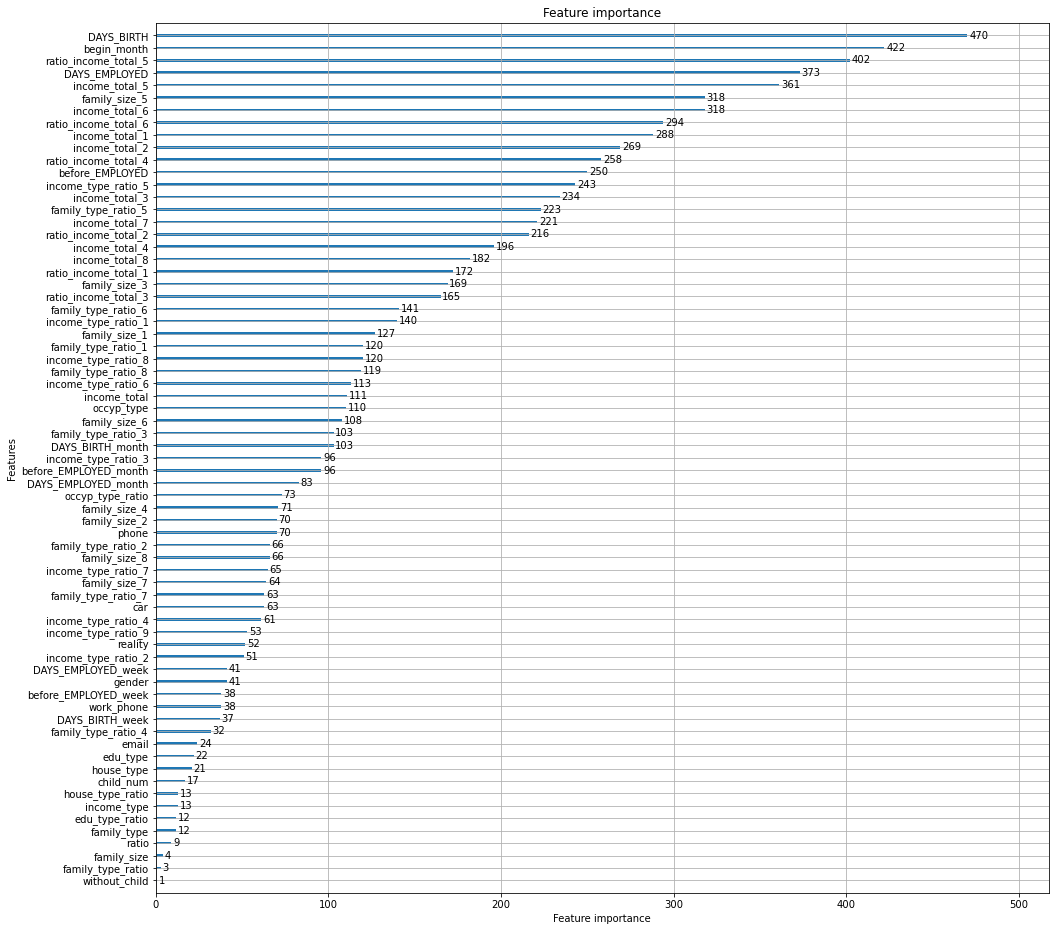

In [37]:
from lightgbm import plot_importance
plot_importance(clf, figsize=(16, 16))

# 제출용 Train

In [112]:
# train는 feature와 target 값 같이 있음
# test는 feature 값만 있다
print(train.shape, test.shape)

skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
folds=[]
for train_idx, valid_idx in skf.split(train, train['credit']):
    folds.append((train_idx, valid_idx))

random.seed(42)
lgb_models={}
for fold in range(10):
    print(f'===================================={fold+1}============================================')
    # 데이터 분할
    train_idx, valid_idx = folds[fold] # 인덱스
    X_train, X_valid, y_train, y_valid = train.drop(['credit'],axis=1).iloc[train_idx].values,\
                                         train.drop(['credit'],axis=1).iloc[valid_idx].values,\
                                         train['credit'][train_idx].values,\
                                         train['credit'][valid_idx].values 
    
    
    # 모델
    lgb = LGBMClassifier(n_estimators=1000)
    
    lgb.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_valid, y_valid)], 
            early_stopping_rounds=50, verbose=100)
    
    
    lgb_models[fold]=lgb
    print(f'================================================================================\n\n')

(26457, 104) (10000, 103)
====================================1============================================
Training until validation scores don't improve for 50 rounds
[100]	training's multi_logloss: 0.590789	valid_1's multi_logloss: 0.710446
[200]	training's multi_logloss: 0.48589	valid_1's multi_logloss: 0.68769
[300]	training's multi_logloss: 0.412997	valid_1's multi_logloss: 0.683721
Early stopping, best iteration is:
[251]	training's multi_logloss: 0.446083	valid_1's multi_logloss: 0.682538


====================================2============================================
Training until validation scores don't improve for 50 rounds
[100]	training's multi_logloss: 0.590548	valid_1's multi_logloss: 0.721722
[200]	training's multi_logloss: 0.488122	valid_1's multi_logloss: 0.695762
[300]	training's multi_logloss: 0.414301	valid_1's multi_logloss: 0.689668
Early stopping, best iteration is:
[299]	training's multi_logloss: 0.415111	valid_1's multi_logloss: 0.689557


================

#### 파라미터 조정

In [113]:
submit.iloc[:,1:]=0
for fold in range(10):
    submit.iloc[:,1:] += lgb_models[fold].predict_proba(test)/10

In [114]:
submit.to_csv('5submission.csv', index=False)

In [115]:
submit.head(20)

,index,0,1,2
0,26457,0.066743,0.183309,0.749949
1,26458,0.262324,0.192055,0.545621
2,26459,0.032888,0.047338,0.919774
3,26460,0.101187,0.151342,0.747471
4,26461,0.117591,0.138811,0.743598
5,26462,0.055611,0.117529,0.826860
6,26463,0.438421,0.560807,0.000772
7,26464,0.107765,0.191051,0.701184
8,26465,0.041148,0.129386,0.829466
9,26466,0.062944,0.349034,0.588022


In [116]:
from sklearn.model_selection import train_test_split
ftr_train = train.drop('credit', axis = 1, inplace = False)
target = train['credit']

train_x, valid_x, train_y, valid_y = train_test_split(ftr_train, target, test_size = 0.2, random_state = 10)
print(train_x.shape, valid_x.shape)

from sklearn.model_selection import cross_val_score

lgb_clf = LGBMClassifier(n_estimators=100, random_state = 22)

scores = cross_val_score(lgb_clf, ftr_train , target , cv=10)

for iter_count,accuracy in enumerate(scores):
    print("교차 검증 {0} 정확도: {1:.4f}".format(iter_count+1, accuracy))

print("평균 정확도: {0:.4f}".format(np.mean(scores))) 
# 0.711 -> 0.6973
# 0.7124

(21165, 103) (5292, 103)
교차 검증 1 정확도: 0.7113
교차 검증 2 정확도: 0.7166
교차 검증 3 정확도: 0.7113
교차 검증 4 정확도: 0.7154
교차 검증 5 정확도: 0.7116
교차 검증 6 정확도: 0.7101
교차 검증 7 정확도: 0.7124
교차 검증 8 정확도: 0.7157
교차 검증 9 정확도: 0.7112
교차 검증 10 정확도: 0.7093
평균 정확도: 0.7125


###  ========================================================================

#### 정규화 및 이상치 제거 


In [ ]:
#candidate = ['income_total', 'DAYS_EMPLOYED', 'family_size']
candidate = ['income_total', 'family_size']
for cand in candidate :
    train[cand] = ((train[cand] - min(train[cand]) / min(train[cand]) - min(train[cand])))
    test[cand] = ((test[cand] - min(test[cand]) / min(test[cand]) - min(test[cand])))
    
    
def remove_outlier(train,column):
    df = train[column]
    # 1분위수
    quan_25 = np.percentile(df.values, 25)
    
    # 3분위수
    quan_75 = np.percentile(df.values, 75)
    
    iqr = quan_75 - quan_25
    
    lowest = quan_25 - iqr * 1.5
    highest = quan_75 + iqr * 1.5
    outlier_index = df[(df < lowest) | (df > highest)].index
    print('outlier의 수 : ' , len(outlier_index))
    train.drop(outlier_index, axis = 0, inplace = True)
    
    return train


#for cand in candidate:  
#    train = remove_outlier(train,cand)
#    test = remove_outlier(test,cand)
#len(train)
#len(test)

#### 상관관계

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

corr = train[train.columns.tolist()].corr()
corr
plt.figure(figsize =(15,15))
sns.heatmap(corr,cmap='RdBu', annot = True) # child_num 삭제

# train.drop('child_num', axis = 1, inplace = True)
# test.drop('child_num', axis = 1, inplace = True)

# 예측

### 5.직업 유형 예측

In [ ]:
train = pd.read_csv('./data/train.csv')
train = train.drop(['index'], axis=1)
train.fillna('NAN', inplace=True) 


test = pd.read_csv('./data/test.csv')
test = test.drop(['index'], axis=1)
test.fillna('NAN', inplace=True)

submit = pd.read_csv('./data/sample_submission.csv')

In [ ]:
## 원핫인코딩 전환
def one_hot_encoding(df_data):
    
    # 범주형 변수 담기
    object_col = []
    for col in df_data.columns:
        if df_data[col].dtype == 'object':
            object_col.append(col)
            
    # occyp_type을 제외한 원핫인코딩
    object_col.remove('occyp_type')
    
    # 원핫인코딩
    enc = OneHotEncoder()
    enc.fit(df_data.loc[:,object_col])
    
    # 데이터 변환
    onhot_df = pd.DataFrame(enc.transform(df_data.loc[:,object_col]).toarray(),\
                                   columns=enc.get_feature_names(object_col))
    df_data.drop(object_col, axis=1, inplace=True)
    df_data = df_data.reset_index()
    onhot_df = onhot_df.reset_index()
    df_data = pd.concat([df_data, onhot_df], axis=1)    

    print("## 원핫 인코딩 진행 완료 ##")
    print(df_data.shape)
    
    return df_data

In [ ]:
## 예측 정확도 파악
def predict_type(df_train_data, df_target_data):
    Train = df_train_data.drop('occyp_type', axis = 1, inplace = False)
    target = df_train_data['occyp_type']

    X_train, X_test, y_train, y_test = train_test_split(Train, target, 
                                                    stratify=target, test_size=0.20,
                                                    random_state = 1000)

    print("## train / test 분할 완료 ##")
    print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)
    
    print("## 예측을 진행합니다 ##")
    rf_clf = RandomForestClassifier(n_estimators = 1000, random_state=20)
    rf_clf.fit(X_train , y_train)
    pred = rf_clf.predict(X_test)
    accuracy = accuracy_score(y_test , pred)
    print('랜덤 포레스트 정확도: {0:.4f}'.format(accuracy)) 
    
    # 적용
    print('모델 적용중.............')
    pred1 = rf_clf.predict(df_target_data)
    
    class_le = LabelEncoder()
    df_train_data['occyp_type'] = class_le.fit_transform(df_train_data['occyp_type'].values)
    
    df_target_data['occyp_type'] = class_le.inverse_transform(pred1).tolist()
    df_target_data['occyp_type'].value_counts()
    print(df_train_data.shape, df_target_data.shape)
    
    final_data = pd.concat([df_train_data.reset_index().drop(['level_0','index'], axis = 1),\
                            df_target_data.reset_index().drop(['level_0','index'], axis = 1)], axis = 0)
    print(final_data['occyp_type'].value_counts())
    print('완료')
    return final_data.reset_index()

#### 원핫적용

In [ ]:
train = one_hot_encoding(train)
test = one_hot_encoding(test)

In [ ]:
train_type = train[train['occyp_type'] != 'NAN']
target_train_type = train[train['occyp_type'] == 'NAN']
    
test_type = test[test['occyp_type'] != 'NAN']
target_test_type = test[test['occyp_type'] == 'NAN']
    
print("## type 여부 분할 완료 ##")
print(train_type.shape, target_train_type.shape, test_type.shape, target_test_type.shape)    

#### 타겟 레이블 인코딩

In [ ]:
class_le = LabelEncoder()
train_type['occyp_type'] = class_le.fit_transform(train_type['occyp_type'].values)
test_type['occyp_type'] = class_le.fit_transform(test_type['occyp_type'].values)

print("## type 여부 분할 완료 ##")
print(train_type.shape, target_train_type.shape, test_type.shape, target_test_type.shape)    

In [ ]:
train_training = train_type.drop(['credit'] , axis = 1, inplace = False)
train_target = target_train_type.drop(['occyp_type','credit'], axis = 1, inplace = False) # ★,'credit'
          
test_training = test_type
test_target = target_test_type.drop(['occyp_type'], axis = 1, inplace = False)
print("## 데이터 분할 완료 ##")
print(train_training.shape, train_target.shape, test_training.shape, test_target.shape)    

### 적용


In [ ]:
train_training.columns

In [ ]:
train = predict_type(train_training, train_target) # 0.8573 -> 원핫적용시 : 
test = predict_type(test_training, test_target) # 0.6818 -> 원핫적용시 : 

In [ ]:
train['occyp_type'] = class_le.inverse_transform(train['occyp_type']).tolist()
test['occyp_type'] = class_le.inverse_transform(test['occyp_type']).tolist()